# Tomography tomorec example notebook
This notebook is an example uses:
* tomopy
* GPU (CUDA build of tomopy)

### Most Recent Update
2020-04-29 11:00 - Jason <br>
Copied what is in https://github.com/tomograms/tomography-notebooks/blob/rajmund/tomorec_lungs.ipynb

## Import modules

In [1]:
%env MKL_NUM_THREADS 1
%env OMP_NUM_THREADS 1
ncore = 8

env: MKL_NUM_THREADS=1
env: OMP_NUM_THREADS=1


In [2]:
import tomopy
import dxchange
import matplotlib.pyplot as plt
import h5py
import time
import tifffile
import numpy as np

/opt/conda/envs/maxiv-jup-conda-env-formax/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Set the path to the micro-CT data to reconstruct.

In [3]:
fp = h5py.File('/mxn/groups/kits/scisw/jupyterhub/data-for-validations/formax/tomorec/VILI_mouse_5_pm2_e.h5','r')
ff = h5py.File('/mxn/groups/kits/scisw/jupyterhub/data-for-validations/formax/tomorec/VILI_mouse_5_pm2_refs.h5','r')

In [4]:
proj = fp['exchange/data']
flat = ff['exchange/data_white']
dark = ff['exchange/data_dark']
print(proj.shape, flat.shape, dark.shape)

(901, 1048, 2016) (100, 1048, 2016) (30, 1048, 2016)


## If the angular information is not available from the raw data you need to set the data collection angles. In this case theta is set as equally spaced between 0-180 degrees.

In [5]:
theta = tomopy.angles(proj.shape[0])

## Perform the flat-field correction of raw data: $$ \frac{proj - dark} {flat - dark} $$

In [6]:
proj = tomopy.normalize(proj, flat, dark)
print(proj.shape)

(901, 1048, 2016)


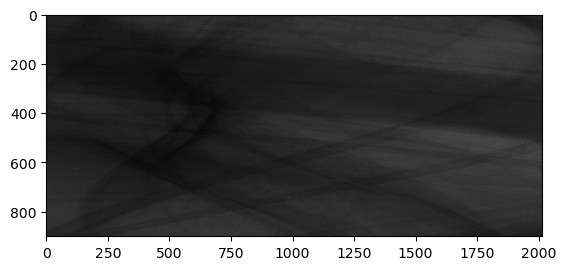

In [7]:
plt.imshow(proj[:,40, :], cmap='Greys_r')
plt.show()

## Tomopy provides various methods to [find rotation center](http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.rotation.html).

In [8]:
rot_center = tomopy.find_center(proj, theta, init=1008, ind=0, tol=0.5)
print(rot_center)

[1002.4875]


In [9]:
proj = tomopy.prep.phase.retrieve_phase(proj, pixel_size=0.0003, dist=10, energy=22, alpha=0.00020, pad=True, ncore=ncore)

## Reconstruction using Gridrec algorithm.Tomopy provides various [reconstruction](http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.algorithm.html) methods including the one part of the [ASTRA toolbox](https://sourceforge.net/p/astra-toolbox/wiki/Home/).

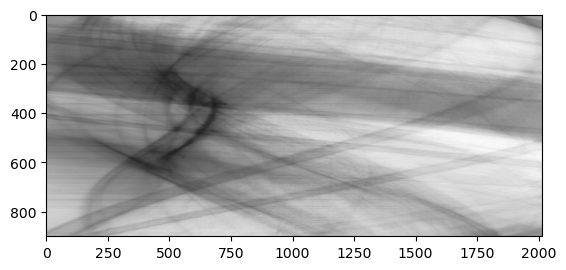

In [10]:
plt.imshow(proj[:, 40,:], cmap='Greys_r')
plt.show()

## Calculate $$ -log(proj) $$

In [11]:
proj = tomopy.minus_log(proj, ncore=ncore)

## Padding to remove the gradient around the FOV in the reconstruction

In [12]:
N = proj.shape[2]
proj_pad = np.zeros([proj.shape[0],proj.shape[1],3*N//2],dtype = "float32")
proj_pad[:,:,N//4:5*N//4] = proj
proj_pad[:,:,0:N//4] = np.tile(np.reshape(proj[:,:,0],[proj.shape[0],proj.shape[1],1]),(1,1,N//4))
proj_pad[:,:,5*N//4:] = np.tile(np.reshape(proj[:,:,-1],[proj.shape[0],proj.shape[1],1]),(1,1,N//4))

proj = proj_pad
rot_center = rot_center+N//4

## Padding for accelerated MLEM/SIRT (optional)

In [13]:
if True:
    if (rot_center<proj.shape[-1]//2):
        npad = int(proj.shape[-1] - 2*rot_center + 0.5)
        print('Projections will be bad by %d pixels left'%npad)
        proj_pad = np.concatenate((np.zeros(proj.shape[:-1]+(npad,),dtype=proj.dtype),proj),axis=proj.ndim-1)
        rot_center_pad = rot_center + npad
    else:
        npad = int(2*rot_center - proj.shape[-1] + 0.5)
        print('Projections will be bad by %d pixels right'%npad)
        proj_pad = np.concatenate((proj,np.zeros(proj.shape[:-1]+(npad,),dtype=proj.dtype)),axis=proj.ndim-1)
        rot_center_pad = rot_center
        
    proj = proj_pad
    rot_center = rot_center_pad

/tmp/ipykernel_504906/1516168199.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  npad = int(proj.shape[-1] - 2*rot_center + 0.5)


Projections will be bad by 11 pixels left


## Select / define tomo algorithms

In [14]:
# algorithm = 'gridrec'
algorithm = 'sirt'

In [15]:
slice_first=500
slice_last=501
aproj=proj[:,slice_first:slice_last,:]
print(aproj.shape)

(901, 1, 3035)


In [16]:
%%time

if algorithm == 'gridrec':
    recon = tomopy.recon(aproj, theta, center=rot_center, algorithm=algorithm, filter_name='parzen')
elif algorithm == "sirt":
    recon = tomopy.recon(aproj, theta, algorithm=algorithm, num_iter=100, accelerated=True, device='gpu', ncore=1, pool_size=3)
# recon = tomopy.recon(aproj, theta, center=rot_center, algorithm=algorithm, accelerated=True, device='gpu')
# recon = tomopy.recon_accelerated(aproj, theta, center=rot_center, algorithm='ospml_hybrid', filter_name='parzen')
# recon = tomopy.recon(aproj, theta, center=rot_center, algorithm=algorithm, filter_name='parzen', device='gpu')

recon = recon[:,N//4:5*N//4,N//4:5*N//4]
        
print("Algorithm: ", algorithm)

Detected 4 CUDA capable devices

Device 0: "Tesla V100-SXM2-32GB"
  CUDA Driver Version / Runtime Version          12.5 / 11.2
  CUDA Capability Major/Minor version number:    7.0
  Total amount of global memory:                 32494 MBytes (34072559616 bytes)
  GPU Max Clock rate:                            1530 MHz (1.53 GHz)
  Memory Clock rate:                             877 Mhz
  Memory Bus Width:                              4096-bit
  L2 Cache Size:                                 6291456 bytes
  Maximum Texture Dimension Size (x,y,z)         1D=(131072), 2D=(131072, 65536), 3D=(16384, 16384, 16384)
  Maximum Layered 1D Texture Size, (num) layers  1D=(32768), 2048 layers
  Maximum Layered 2D Texture Size, (num) layers  2D=(32768, 32768), 2048 layers
  Total amount of constant memory:               65536 bytes
  Total amount of shared memory per block:       49152 bytes
  Total number of registers available per block: 65536
  Warp size:                                     32
  

[0]> cxx_sirt : nitr = 100, dy = 1, dt = 901, dx = 3035, nx = 3035, ny = 3035
[0]> sirt_cuda : nitr = 100, dy = 1, dt = 901, dx = 3035, nx = 3035, ny = 3035
[0] Running on device 0...
[0]> iteration        ::   0 of 100...  1.20 seconds
[0]> iteration        ::   1 of 100...  1.20 seconds
[0]> iteration        ::   2 of 100...  1.21 seconds
[0]> iteration        ::   3 of 100...  1.21 seconds
[0]> iteration        ::   4 of 100...  1.21 seconds
[0]> iteration        ::   5 of 100...  1.21 seconds
[0]> iteration        ::   6 of 100...  1.21 seconds
[0]> iteration        ::   7 of 100...  1.21 seconds
[0]> iteration        ::   8 of 100...  1.21 seconds
[0]> iteration        ::   9 of 100...  1.20 seconds
[0]> iteration        ::  10 of 100...  1.21 seconds
[0]> iteration        ::  11 of 100...  1.20 seconds
[0]> iteration        ::  12 of 100...  1.20 seconds
[0]> iteration        ::  13 of 100...  1.20 seconds
[0]> iteration        ::  14 of 100...  1.20 seconds
[0]> iteration       

Algorithm:  sirt
CPU times: user 5min 43s, sys: 17.4 s, total: 6min
Wall time: 2min 1s


In [17]:
print(recon.shape)

(1, 2016, 2016)


## Mask each reconstructed slice with a circle.

In [18]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95, ncore=ncore)

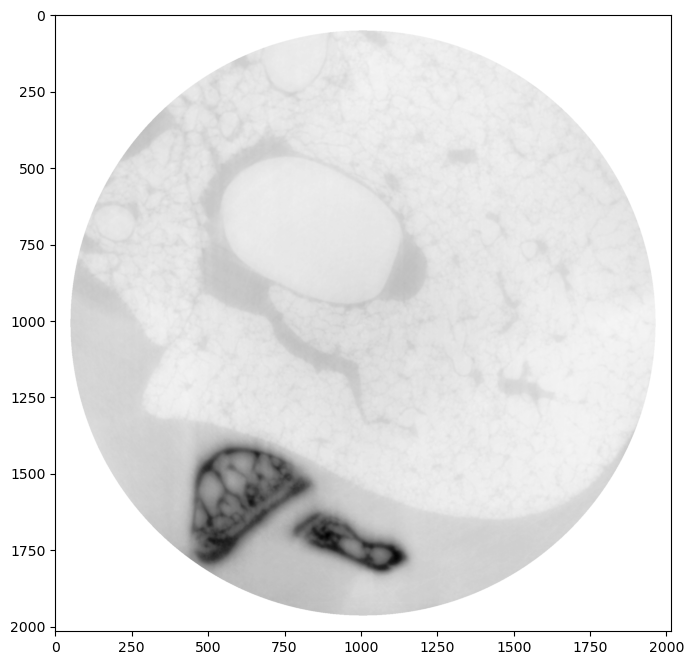

In [19]:
fig = plt.figure(figsize=(9,8))
plt.imshow(recon[0, :,:], cmap='Greys')
plt.show()

### Save as tiff file

In [20]:
from PIL import Image
from io import BytesIO

png1 = BytesIO()
fig.savefig(png1, format='png')
png2 = Image.open(png1)
png2.save('/mxn/groups/kits/scisw/jupyterhub/data-for-validations/formax/tomorec/output/sirt_alpha15e-5.tiff')